In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

## Problem1

In [2]:
# Read in data from csv
data = pd.read_csv("DailyReturn.csv")
# df drop the first column of time stamp
df = data.iloc[:,1:]

In [3]:
# Generate weights
# w: weight for time t
def weights_gen(lamda,t):
    # Initialize values
    tw = 0
    w = np.zeros(t)
    # calculate weights
    for i in range(t):
        w[i] = (1-lamda)*lamda ** (t-i-1)
        tw += w[i]
    for i in range(t):
        w[i] = w[i]/tw
    return w

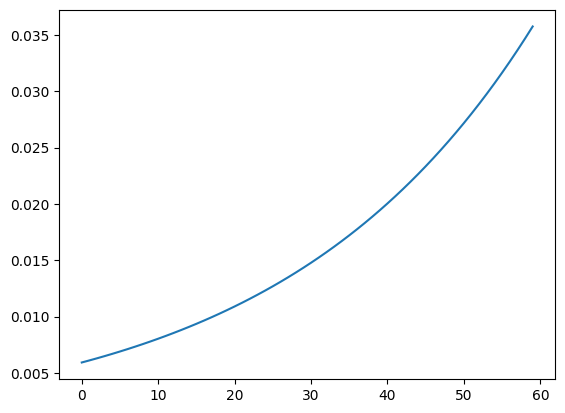

In [22]:
plt.plot(weights_gen(0.97,60))

In [4]:
# calculate weighted covariance
def weights_cov(data,lamda):
    # number of stocks
    n = data.shape[1]
    # length of time
    t = data.shape[0]
    # Call weights generating function to generate weights
    w = weights_gen(lamda,t)
    # Initialize a cov matrix
    cov = np.zeros((n,n))
    # the array of mean for each stock
    means = np.array(data.mean())
    for i in range(n):
        for j in range(n):
            cov[i][j] = np.sum((data.iloc[:,i]-means[i])*(data.iloc[:,j]-means[j])*w)
    return cov

In [5]:
def pca_vecs(cov):
    eigvalues, eigvector = np.linalg.eigh(cov)
    # Sort the eig values and vector
    vals = np.flip(eigvalues)
    vecs = np.flip(eigvector,axis=1)
    # Only use the positive eigen values
    posv_ind = np.where(vals >= 1e-8)[0]
    vals = vals[posv_ind]
    vecs = vecs[:,posv_ind]
    vals = np.real(vals)
    return vals,vecs

In [6]:
def pca_pct(vals):
    # Total eigen values
    tv = vals.sum()
    pct_dic = {}
    for k in range(len(vals)):
        pct = vals[:k+1].sum()/tv
        pct_dic[k]=pct
    pct_series = pd.Series(pct_dic)
    return pct_series

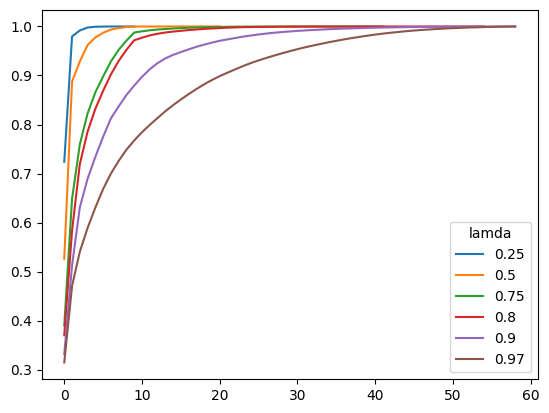

In [7]:
# Set the lamda value list
lamda = [0.25,0.5,0.75,0.8,0.9,0.97]
for l in lamda:
    cov_w = weights_cov(df,l)
    vals = pca_vecs(cov_w)[0]
    pct = pca_pct(vals)
    plt.plot(pct,label ="{}".format(l))
plt.legend(title='lamda')

## Problem 2

In [34]:
# Cholesky that assumes PSD
def chol_psd(a):
    n= a.shape[0]
    root = np.zeros((n,n))
    for j in range(n):
        # s is the sum of square of values for row j subtracted from A_jj
        s=0
        if j>0:
            s = root[j,:j].T @ root[j,:j]
        # diagonal element
        temp = a[j,j] - s
        if temp <= 0 and temp >= -1e-8:
            temp =0
        root[j,j] = math.sqrt(temp)
        # Set column to 0 for 0 eigen values
        if root[j,j] == 0:
            root[j+1:n,j] = 0
        else:
            ir = 1/root[j,j]
            for i in range(j+1,n):
                s = root[i,:j].T @ root[j,:j]
                root[i,j] = (a[i,j]-s)*ir
    return root

In [35]:
def near_psd(a,epsilon=0):
    n= a.shape[0]
    invSD = None
    out = a.copy()
    #  Convert to correlation if we get a covariance
    if (np.diag(out)==1).sum() != n:
        invSD = np.diag(1/np.sqrt(np.diag(out)))
        out = invSD @ out @ invSD
    #  Update eigen value and scale
    vals, vecs = np.linalg.eigh(out)
    # adjust eigen values to non negative
    vals[vals<epsilon]=0
    T = 1/(vecs * vecs @ vals)
    T = np.diag(np.sqrt(T))
    l = np.diag(np.sqrt(vals))
    B = T @ vecs @ l
    out = B @ B.T
    # Add back to variance
    if invSD is not None:
        invSD = np.diag(1/np.diag(invSD))
        out = invSD @ out @ invSD
    return out

In [40]:
# The first projection
def pu(x):
    n = x.shape[0]
    x_pu = x.copy()
    for i in range(n):
        for j in range(n):
            if i==j:
                x_pu[i][j]=1
    return x_pu

# The second projection
def ps(x,w=None):
    n = x.shape[0]
    if w != None:
        # parameter pass in array of diags
        w_diag = np.diag(w)
    else:
        w_diag = np.diag(np.ones(n))
    x_w = np.sqrt(w_diag) @ x @ np.sqrt(w_diag)
    # Perform (A)+ on weighted A
    vals, vecs = np.linalg.eigh(x_w)
    vals[vals<1e-8]=0
    l = np.diag(vals)
    # The adjusted A
    x_pos = vecs @ l @ vecs.T
    w_inv = np.linalg.inv(np.sqrt(w_diag))
    out = w_inv @ x_pos @ w_inv
    return out

# Calculate Frobenius Norm
def fnorm(x):
    n = x.shape[0]
    result = 0
    for i in range(n):
        for j in range(n):
            result += x[i][j] ** 2
    return result

# k: max iteration
def higham(a,gamma0=np.inf,K=100,tol=1e-08):
    delta_s = [0]
    gamma = [gamma0]
    Y = [a]
    for k in range(1,K+1):
        R_k = Y[k-1] - delta_s[k-1]
        X_k = ps(R_k)
        delta_s_k = X_k - R_k
        delta_s.append(delta_s_k)
        Y_k = pu(X_k)
        Y.append(Y_k)
        gamma_k = fnorm(Y_k-a)
        gamma.append(gamma_k)
        if gamma_k -gamma[k-1] < tol:
            vals = np.linalg.eigh(Y_k)[0]
            if vals.min() >= 1e-8:
                break
            else:
                continue
    return Y[-1]

In [37]:
# Gnerate a non-psd correlation matrix
def npsd(n):
    sigma = np.empty((n,n))
    sigma.fill(0.9)
    for i in range(n):
        sigma[i,i]=1
    sigma[0,1]=0.7357
    sigma[1,0]=0.7357
    return sigma

In [44]:
# Compare results with N increasing
size=[5,50,100,500]
# Near PSD
for n in size:
    print("size: {}".format(n))
    sigma = npsd(n)
    fixed_near = near_psd(sigma)
    # Check if the fixed matrix is PSD
    vals_fixed = np.linalg.eigh(fixed_near)[0]
    assert(vals_fixed.min() >= -1e-8)
    near_diff = fnorm(fixed_near-sigma)
    print("Result diff:{}".format(near_diff))

# Compare runtime with N increasing
for n in size:
    print("Runtime of size {}".format(n))
    sigma = npsd(n)
    %timeit near_psd(sigma)

size: 5
Result diff:1.465220408915046e-10
size: 50
Result diff:0.034479029796029646
size: 100
Result diff:0.07441520643485923
size: 500
Result diff:0.3937846835022174
Runtime of size 5
The slowest run took 5.41 times longer than the fastest. This could mean that an intermediate result is being cached.
194 µs ± 152 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Runtime of size 50
668 µs ± 130 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Runtime of size 100
1.99 ms ± 670 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Runtime of size 500
56.9 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
#Higham
for n in size:
    print("size: {}".format(n))
    sigma = npsd(n)
    fixed_h = higham(sigma)
    vals_fixed = np.linalg.eigh(fixed_near)[0]
    assert(vals_fixed.min() >= -1e-08)
    h_diff = fnorm(fixed_h-sigma)
    print("Result diff: {}".format(h_diff))

for n in size:
    print("Runtime of size {}".format(n))
    sigma = npsd(n)
    %timeit higham(sigma)

size: 5
Result diff: 1.0224674596136205e-10
size: 50
Result diff: 0.006189339461809019
size: 100
Result diff: 0.007164374615644757
size: 500
Result diff: 0.008036763251104704
Runtime of size 5
16.7 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Runtime of size 50
436 ms ± 168 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Runtime of size 100
1.22 s ± 380 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Runtime of size 500
39 s ± 6.56 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Problem 3

In [46]:
# Pearson correlation and var
def pcor_var(df):
    n = df.shape[1]
    vars = []
    # Get the standard variance for each asset
    for i in range(n):
        var_i = df.iloc[:,i].var()
        vars.append(var_i)
    std = np.sqrt(vars)
    # Get the pearson correlation matrix
    corr = np.corrcoef(df,rowvar=False)
    cov = np.empty((n,n))
    for i in range(n):
        for j in range(n):
            cov[i][j]= std[i]*std[j]*corr[i,j]
    return cov

In [47]:
# Pearson correlation and EW variance
def pcor_ew(df):
    t,n = df.shape
    # The weights generation function defined above
    w = weights_gen(0.97,t)
    ew_vars = []
    # Calculate the weighted variance
    for i in range(n):
        mean_i = df.iloc[:,i].mean()
        var_i = ((df.iloc[:,i]-mean_i) ** 2 * w).sum()
        ew_vars.append(var_i)
    ew_std = np.sqrt(ew_vars)
    corr = np.corrcoef(df,rowvar=False)
    cov = np.empty((n,n))
    for i in range(n):
        for j in range(n):
            cov[i][j]= ew_std[i]*ew_std[j]*corr[i,j]
    return cov

In [48]:
# EW(cov+corr) is the function weights_cov(df,0.97) defined above
def ew_cov(df):
    return weights_cov(df,0.97)

In [49]:
# EW Corr +Var
def ewcor_var(df):
    t,n = df.shape
    ew_cov = weights_cov(df,0.97)
    # Get the weighted variance
    w = weights_gen(0.97,t)
    ew_vars = []
    for i in range(n):
        mean_i = df.iloc[:,i].mean()
        var_i = ((df.iloc[:,i]-mean_i) ** 2 * w).sum()
        ew_vars.append(var_i)
    ew_std = np.sqrt(ew_vars)
    # Get the weighted corr
    ew_corr = np.empty((n,n))
    for i in range(n):
        for j in range(n):
            ew_corr[i][j]= ew_cov[i][j]/(ew_std[i]*ew_std[j])
    #  Get the no weight variance
    vars = []
    for i in range(n):
        var_i = df.iloc[:,i].var()
        vars.append(var_i)
    std = np.sqrt(vars)
    #  Get the final cov
    cov = np.empty((n,n))
    for i in range(n):
        for j in range(n):
            cov[i][j]= std[i]*std[j]*ew_corr[i,j]
    return cov

In [50]:
# Calculate vals based on pct explained
def vals_pct(vals,vecs,pct):
    # Total eigen values
    tv = vals.sum()
    for k in range(len(vals)):
        explained = vals[:k+1].sum()/tv
        if explained >= pct:
            break
    return vals[:k+1],vecs[:,:k+1]

In [51]:
#Simulation
def pca_simulate(a,nsim,pct=None):
    # Use the pca function above
    vals,vecs = pca_vecs(a)
    # If pct is given
    if pct != None:
        vals,vecs = vals_pct(vals,vecs,pct)
    B = vecs @ np.diag(np.sqrt(vals))
    m = vals.size
    r = np.random.normal(size=(m,nsim))
    out = (B @ r).T
    return out

In [55]:
pct = [None,0.75,0.5]
cov_opt = [pcor_var,pcor_ew,ew_cov,ewcor_var]
# Simulation for each pair of pct and cov
for p in pct:
    for cov_f in cov_opt:
        # The input cov
        cov_in = cov_f(df)
        # Simulate the cov
        s = pca_simulate(cov_in,25000,p)
        cov_out = np.cov(s,rowvar=False)
        # Compare the result
        diff = fnorm(cov_out -cov_in)
        print("result difference for {} at pct {} :{}".format(cov_f,p,diff))

for p in pct:
    for cov_f in cov_opt:
        # The input cov
        cov_in = cov_f(df)
        # Simulate the cov
        print("Runtime for {} with {} pca".format(cov_f,p))
        %timeit pca_simulate(cov_in,25000,p)

result difference for <function pcor_var at 0x1172dcaf0> at pct None :3.8170715327756914e-08
result difference for <function pcor_ew at 0x1172dd000> at pct None :3.8001228982171837e-08
result difference for <function ew_cov at 0x1172dc1f0> at pct None :6.42093346256517e-08
result difference for <function ewcor_var at 0x1172dc8b0> at pct None :5.72959978936944e-08
result difference for <function pcor_var at 0x1172dcaf0> at pct 0.75 :2.6985805449184057e-06
result difference for <function pcor_ew at 0x1172dd000> at pct 0.75 :2.4750390094520504e-06
result difference for <function ew_cov at 0x1172dc1f0> at pct 0.75 :2.4410714828430645e-06
result difference for <function ewcor_var at 0x1172dc8b0> at pct 0.75 :2.780683362537041e-06
result difference for <function pcor_var at 0x1172dcaf0> at pct 0.5 :1.1139778648854818e-05
result difference for <function pcor_ew at 0x1172dd000> at pct 0.5 :1.03801467383504e-05
result difference for <function ew_cov at 0x1172dc1f0> at pct 0.5 :1.192938448119304